<a href="https://colab.research.google.com/github/eksq1/dodo/blob/main/inclass/CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 설정

In [1]:
import sys

assert sys.version_info >= (3, 7)

In [2]:
from packaging import version
import sklearn

assert version.parse(sklearn.__version__) >= version.parse("1.0.1")

In [3]:
import tensorflow as tf

assert version.parse(tf.__version__) >= version.parse("2.8.0")

In [11]:
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

import sys
# 코랩의 경우 나눔 폰트를 설치합니다.
if 'google.colab' in sys.modules:
    !sudo apt-get -qq -y install fonts-nanum
    import matplotlib.font_manager as fm
    font_files = fm.findSystemFonts(fontpaths=['/usr/share/fonts/truetype/nanum'])
    for fpath in font_files:
        fm.fontManager.addfont(fpath)

# 나눔 폰트를 사용합니다.
import matplotlib

matplotlib.rc('font', family='NanumBarunGothic')
matplotlib.rcParams['axes.unicode_minus'] = False

debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Reading database ... 121753 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20200506-1_all.deb ...
Unpacking fonts-nanum (20200506-1) ...
Setting up fonts-nanum (20200506-1) ...
Processing triggers for fontconfig (2.13.1-4.2ubuntu5) ...


In [10]:
# 이 노트북이 Colab에서 실행되고 있나요?
IS_COLAB = "google.colab" in sys.modules

if not tf.config.list_physical_devices('GPU'):
    print("GPU가 감지되지 않았습니다. 신경망은 GPU가 없으면 매우 느릴 수 있습니다.")
    if IS_COLAB:
        print("런타임 > 런타임 유형 변경으로 이동하여 GPU를 선택하세요.")

GPU가 감지되지 않았습니다. 신경망은 GPU가 없으면 매우 느릴 수 있습니다.
런타임 > 런타임 유형 변경으로 이동하여 GPU를 선택하세요.


## 합성곱 층
### 케라스로 합성곱 층 구현하기

In [4]:
from sklearn.datasets import load_sample_images
import tensorflow as tf

images = load_sample_images()["images"]
images = tf.keras.layers.CenterCrop(height=70, width=120)(images)
images = tf.keras.layers.Rescaling(scale=1 / 255)(images)

In [5]:
images.shape

TensorShape([2, 70, 120, 3])

In [6]:
tf.random.set_seed(42)  # 추가 코드 - 재현성 보장
conv_layer = tf.keras.layers.Conv2D(filters=32, kernel_size=7)
fmaps = conv_layer(images)

In [7]:
fmaps.shape

TensorShape([2, 64, 114, 32])

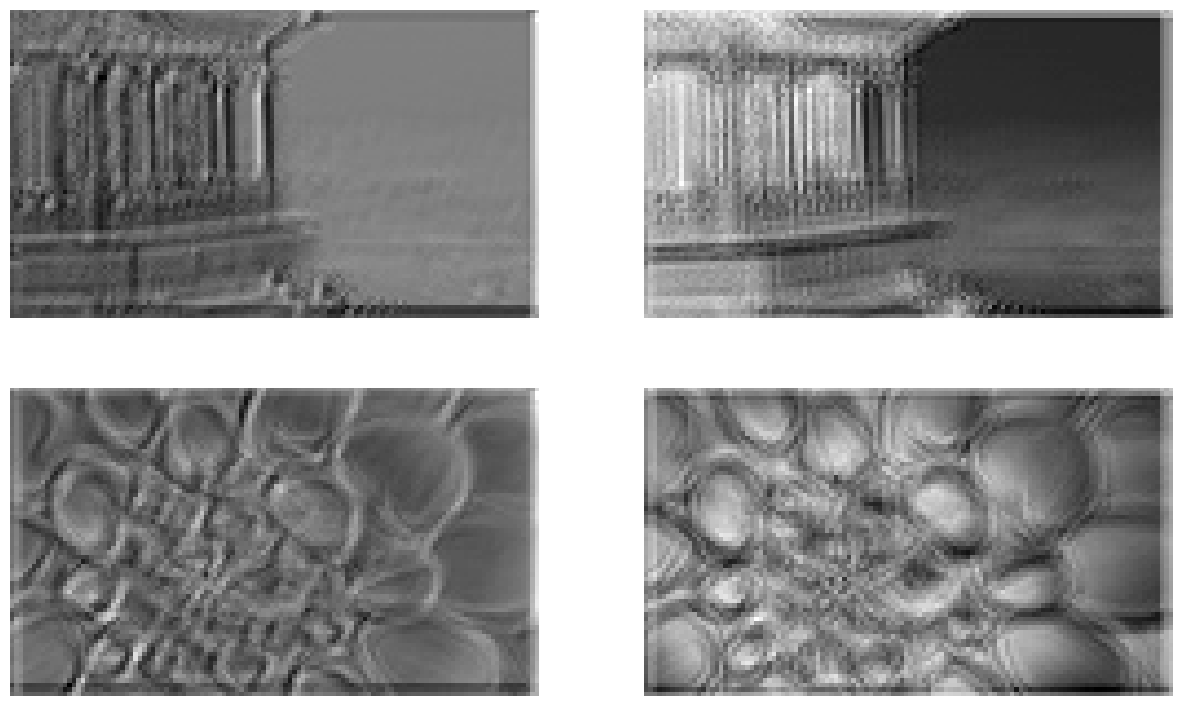

In [12]:
# 추가 코드 - 각 이미지에 대해 두 개의 출력 특성 맵을 표시합니다.

plt.figure(figsize=(15, 9))
for image_idx in (0, 1):
    for fmap_idx in (0, 1):
        plt.subplot(2, 2, image_idx * 2 + fmap_idx + 1)
        plt.imshow(fmaps[image_idx, :, :, fmap_idx], cmap="gray")
        plt.axis("off")

plt.show()

In [9]:
conv_layer = tf.keras.layers.Conv2D(filters=32, kernel_size=7,
                                    padding="same")
fmaps = conv_layer(images)

In [13]:
fmaps.shape

TensorShape([2, 70, 120, 32])

In [14]:
# 추가 코드 - strides=2로 설정했을 때의 출력 크기를 보여줍니다.
conv_layer = tf.keras.layers.Conv2D(filters=32, kernel_size=7, padding="same",
                                    strides=2)
fmaps = conv_layer(images)
fmaps.shape

TensorShape([2, 35, 60, 32])

In [15]:
# 추가 코드 - 이 유틸리티 함수는 합성곱 층에서 출력되는 특성 맵의 크기를 계산합니다.
# 패딩이 "valid"인 경우 무시된 행 또는 열의 수를 반환하고, 패딩이
# "same"인 경우 제로 패딩된 행 또는 열의 수를 반환합니다.

import numpy as np

def conv_output_size(input_size, kernel_size, strides=1, padding="valid"):
    if padding=="valid":
        z = input_size - kernel_size + strides
        output_size = z // strides
        num_ignored = z % strides
        return output_size, num_ignored
    else:
        output_size = (input_size - 1) // strides + 1
        num_padded = (output_size - 1) * strides + kernel_size - input_size
        return output_size, num_padded

conv_output_size(np.array([70, 120]), kernel_size=7, strides=2, padding="same")

(array([35, 60]), array([5, 5]))

In [16]:
kernels, biases = conv_layer.get_weights()
kernels.shape

(7, 7, 3, 32)

In [17]:
biases.shape

(32,)

In [18]:
# 추가 코드 - tf.nn.conv2d() 연산 사용 방법을 보여줍니다.

tf.random.set_seed(42)
filters = tf.random.normal([7, 7, 3, 2])
biases = tf.zeros([2])
fmaps = tf.nn.conv2d(images, filters, strides=1, padding="SAME") + biases

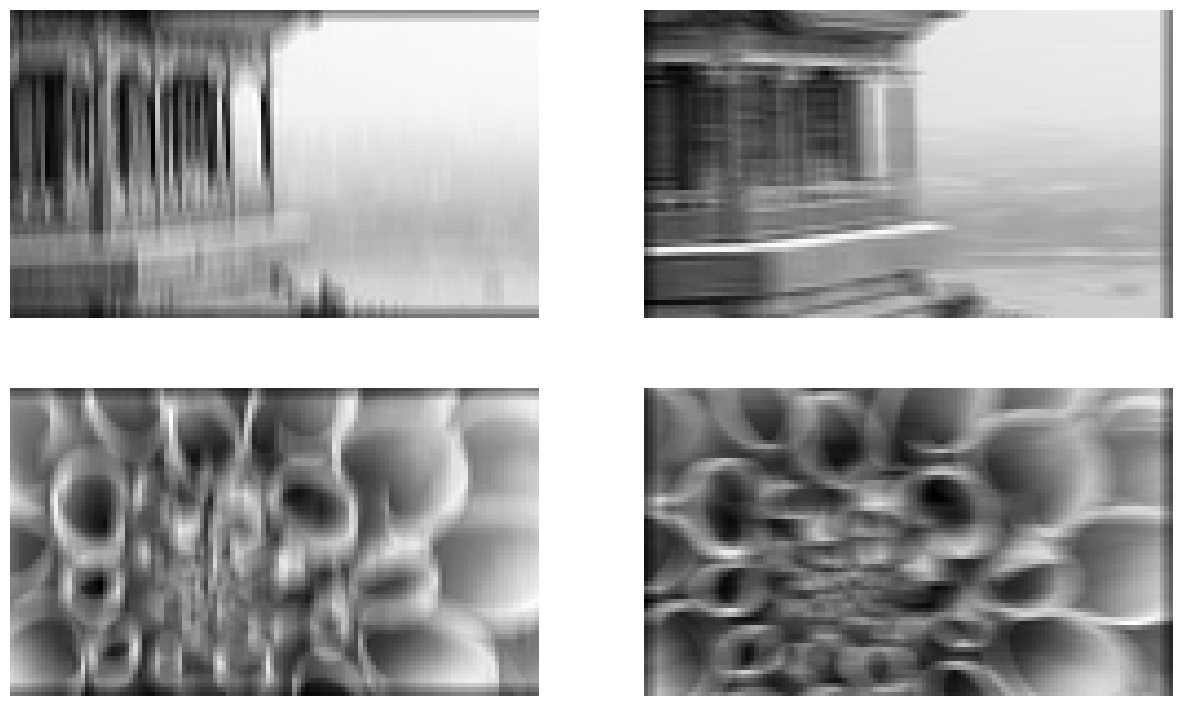

In [19]:
# 추가 코드 - 그림 14-5와 유사한 이미지를 얻기 위해 두 개의 필터를 수동으로 생성하는 방법을 보여줍니다.

plt.figure(figsize=(15, 9))
filters = np.zeros([7, 7, 3, 2])
filters[:, 3, :, 0] = 1
filters[3, :, :, 1] = 1
fmaps = tf.nn.conv2d(images, filters, strides=1, padding="SAME") + biases

for image_idx in (0, 1):
    for fmap_idx in (0, 1):
        plt.subplot(2, 2, image_idx * 2 + fmap_idx + 1)
        plt.imshow(fmaps[image_idx, :, :, fmap_idx], cmap="gray")
        plt.axis("off")

plt.show()

## 풀링
### 케라스로 풀링 층 구현하기

##### **최대 풀링**

In [20]:
max_pool = tf.keras.layers.MaxPool2D(pool_size=2)

In [21]:
output = max_pool(images)

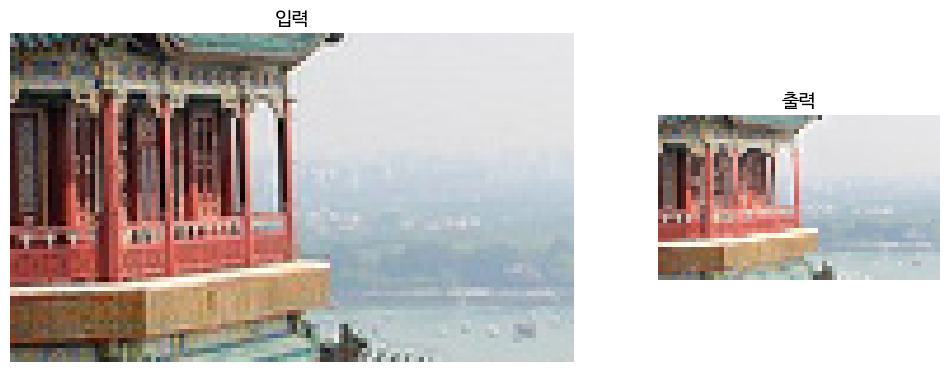

In [22]:
# 추가 코드 - 이 셀은 stride = 2인 최대 풀링이 어떻게 보이는지 보여줍니다.

import matplotlib as mpl

fig = plt.figure(figsize=(12, 8))
gs = mpl.gridspec.GridSpec(nrows=1, ncols=2, width_ratios=[2, 1])

ax1 = fig.add_subplot(gs[0, 0])
ax1.set_title("입력")
ax1.imshow(images[0])  # 첫 번째 이미지 그리기
ax1.axis("off")
ax2 = fig.add_subplot(gs[0, 1])
ax2.set_title("출력")
ax2.imshow(output[0])  # 첫 번째 이미지의 출력을 그립니다.
ax2.axis("off")
plt.show()

##### **깊이별 풀링**

In [23]:
# 추가 코드 - max_pool() 연산자를 사용하는 방법을 보여줍니다. 이 연산은 CPU에서만 동작합니다.
np.random.seed(42)
fmaps = np.random.rand(2, 70, 120, 60)
with tf.device("/cpu:0"):
    output = tf.nn.max_pool(fmaps, ksize=(1, 1, 1, 3), strides=(1, 1, 1, 3),
                            padding="VALID")
output.shape

TensorShape([2, 70, 120, 20])

In [24]:
class DepthPool(tf.keras.layers.Layer):
    def __init__(self, pool_size=2, **kwargs):
        super().__init__(**kwargs)
        self.pool_size = pool_size

    def call(self, inputs):
        shape = tf.shape(inputs)  # shape[-1]는 채널 개수입니다.
        groups = shape[-1] // self.pool_size  # 채널 그룹 수
        new_shape = tf.concat([shape[:-1], [groups, self.pool_size]], axis=0)
        return tf.reduce_max(tf.reshape(inputs, new_shape), axis=-1)

In [25]:
# 추가 코드 - 이 사용자 정의 층이 max_pool()과 동일한 결과를 제공함을 보여줍니다.
np.allclose(DepthPool(pool_size=3)(fmaps), output)

True

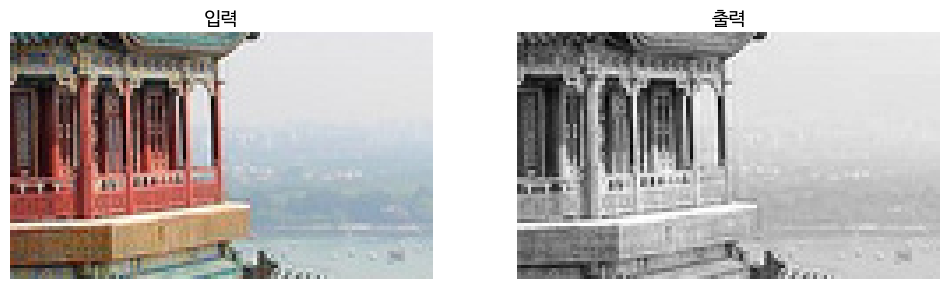

In [26]:
# 추가 코드 - 깊이별 풀링 층의 출력을 계산하고 표시합니다.

depth_output = DepthPool(pool_size=3)(images)

plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.title("입력")
plt.imshow(images[0])  # 첫 번째 이미지를 그립니다.
plt.axis("off")
plt.subplot(1, 2, 2)
plt.title("출력")
plt.imshow(depth_output[0, ..., 0], cmap="gray")  # 첫 번째 이미지의 출력을 그립니다.
plt.axis("off")
plt.show()

##### **전역 평균 풀링**

In [27]:
global_avg_pool = tf.keras.layers.GlobalAvgPool2D()

In [28]:
global_avg_pool = tf.keras.layers.Lambda(
    lambda X: tf.reduce_mean(X, axis=[1, 2]))

In [29]:
global_avg_pool(images)

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[0.64338624, 0.5971759 , 0.5824972 ],
       [0.76306933, 0.2601113 , 0.10849128]], dtype=float32)>

## CNN 구조
##### CNN으로 패션 MNIST 문제 도전하기

In [30]:
# 추가 코드 - mnist 데이터 세트를 로드하고 입력에 채널 축을 추가합니다,
#          값을 0-1 범위로 스케일링하고 데이터셋을 분할합니다.
mnist = tf.keras.datasets.fashion_mnist.load_data()
(X_train_full, y_train_full), (X_test, y_test) = mnist
X_train_full = np.expand_dims(X_train_full, axis=-1).astype(np.float32) / 255
X_test = np.expand_dims(X_test.astype(np.float32), axis=-1) / 255
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

4422102/4422102 [==============================] - 0s 0us/step


In [31]:
from functools import partial

tf.random.set_seed(42)  # 추가 코드 - 재현성 보장
DefaultConv2D = partial(tf.keras.layers.Conv2D, kernel_size=3, padding="same",
                        activation="relu", kernel_initializer="he_normal")
model = tf.keras.Sequential([
    DefaultConv2D(filters=64, kernel_size=7, input_shape=[28, 28, 1]),
    tf.keras.layers.MaxPool2D(),
    DefaultConv2D(filters=128),
    DefaultConv2D(filters=128),
    tf.keras.layers.MaxPool2D(),
    DefaultConv2D(filters=256),
    DefaultConv2D(filters=256),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=128, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(units=64, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(units=10, activation="softmax")
])

In [32]:
# 추가 코드 - 모델을 컴파일, 훈련, 평가하고 예측을 만듭니다.
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam",
              metrics=["accuracy"])
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))
score = model.evaluate(X_test, y_test)
X_new = X_test[:10]  # 새 이미지가 있다고 가정합니다.
y_pred = model.predict(X_new)

Epoch 1/10
1719/1719 [==============================] - 822s 474ms/step - loss: 0.7140 - accuracy: 0.7531 - val_loss: 0.3738 - val_accuracy: 0.8672
Epoch 2/10
1719/1719 [==============================] - 781s 454ms/step - loss: 0.4140 - accuracy: 0.8611 - val_loss: 0.3371 - val_accuracy: 0.8770
Epoch 3/10
 845/1719 [=============>................] - ETA: 6:23 - loss: 0.3573 - accuracy: 0.8761

KeyboardInterrupt: 